# DataFrame sort-agnostic equality test

In [1]:
import time
import timeit
import unittest

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.util.testing import assert_frame_equal, assert_series_equal
import seaborn as sns

In [103]:
def frame_equal_sort(df1, df2):
    """Test equality between two DataFrames,
    ignoring ordering of rows by using sort_index.
    """
    return df1.sort_index().equals(df2.sort_index())


def frame_equal_reindex(df1, df2):
    """Test equality between two DataFrames,
    ignoring ordering of rows by using sort_index.
    """
    if not df1.index.is_unique:
        raise ValueError('DataFrames must have unique indices.')
    if df1.shape != df2.shape:
        return False
    return df1.equals(df2.reindex_like(df1))

def frame_equal_sort(df1, df2):
    """Test equality between two DataFrames,
    ignoring ordering of rows by using sort_index.
    """
    try:
        assert_frame_equal(df1.sort_index(), df2.sort_index())
        return True
    except AssertionError:
        return False


def frame_equal_reindex(df1, df2):
    """Test equality between two DataFrames,
    ignoring ordering of rows by using sort_index.
    """
    try:
        assert_frame_equal(df1, df2, check_like=True)
        return True
    except AssertionError:
        return False


def frame_equal_apply(df1, df2):
    """Using index getting, assert that two dataframes are equal,
    ignoring ordering of rows.
    """
    df1, df2 = df1.T, df2.T
    return df1.apply(lambda row: row.equals(df2[row.name])).all()

In [104]:
def time_equals(eq_func, df1, df2, n_iter):
    
    start = time.time()
    for _ in range(n_iter):
        _ = eq_func(df1, df2)
    end = time.time()
    avg_ms = (end-start)*1e4 / n_iter
    
    return avg_ms

def plot_equals_performance(data, eq_func, n_steps, n_iter):
    
    avgs = []
    step_size = len(data)//n_steps
    
    for n_rows in range(0, len(data)+3, step_size):
        n_rows = n_rows + 2 if n_rows == 0 else n_rows
        df1 = data.iloc[:n_rows].sample(frac=1, random_state=4)
        df2 = data.iloc[:n_rows].sample(frac=1, random_state=42)
        
        avg_ms = time_equals(eq_func, df1, df2, n_iter)
        avgs.append((n_rows, avg_ms))
        
    return pd.DataFrame(avgs, columns=['n_rows', 'avg_ms'])

In [121]:
size = 1e6
data = pd.DataFrame(list(range(int(size))))

n_steps = 30
n_iter = 6
reindex_int = plot_equals_performance(data, frame_equal_reindex,
                                      n_steps=n_steps, n_iter=n_iter)
sort_int    = plot_equals_performance(data, frame_equal_sort,
                                      n_steps=n_steps, n_iter=n_iter)

data.index  = data.index.astype(str)
reindex_str = plot_equals_performance(data, frame_equal_reindex,
                                      n_steps=n_steps//2, n_iter=n_iter//2)
sort_str    = plot_equals_performance(data, frame_equal_sort,
                                      n_steps=5, n_iter=n_iter)

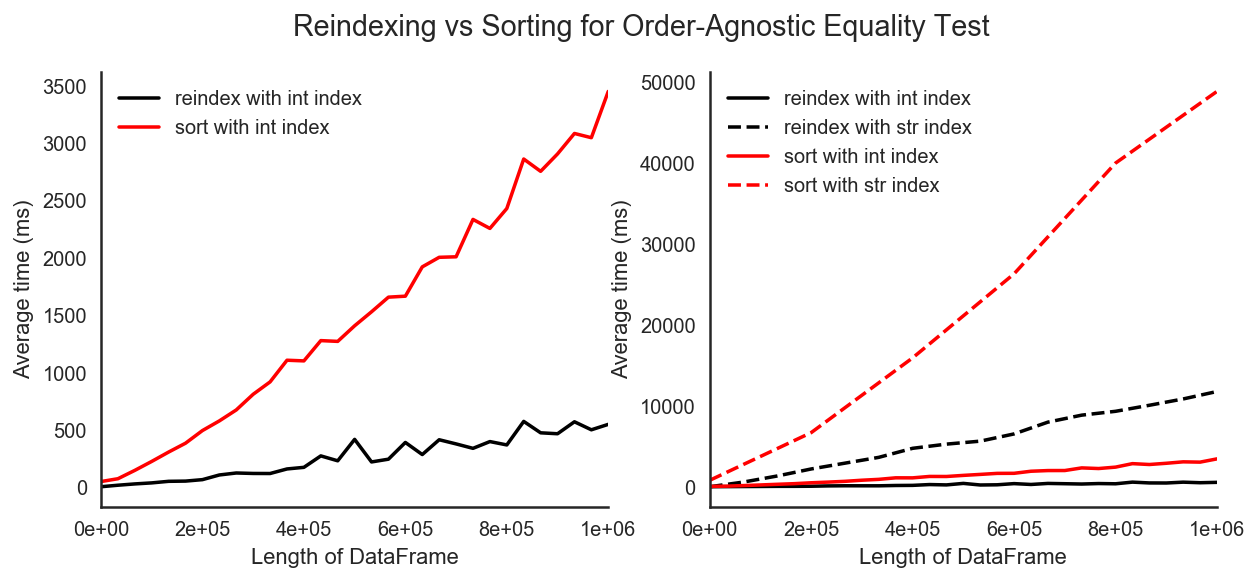

In [198]:
sns.set(style='white', palette='deep')

fig, axs = plt.subplots(ncols=2, figsize=(10, 4))

first = True
for ax in axs:
    
    colormap = 'Greys_r'
    reindex_int.plot(x='n_rows', y='avg_ms', ax=ax, colormap=colormap,
                     label='reindex with int index')
    if not first:
        reindex_str.plot(x='n_rows', y='avg_ms', ax=ax, style='--', colormap=colormap,
                         label='reindex with str index')

    colormap = 'autumn'
    sort_int.plot(x='n_rows', y='avg_ms', ax=ax, colormap=colormap,
                  label='sort with int index')
    if not first:
        sort_str.plot(x='n_rows', y='avg_ms', ax=ax, style='--', colormap=colormap,
                      label='sort with str index')
    
    labels = ax.get_xticks()
    labels = ['{:.0e}'.format(int(lbl)) for lbl in labels]
    ax.set_xticklabels(labels)

#     ax.legend(fontsize='large')
    ax.set_ylabel('Average time (ms)')
    ax.set_xlabel('Length of DataFrame')
#     ax.set_title('Reindexing vs Sorting for Order-Agnostic Equality Test',
#                  fontsize='large'
#     )

#     for item in ([ax.xaxis.label, ax.yaxis.label] +
#                  ax.get_xticklabels() + ax.get_yticklabels()):
#         item.set_fontsize(13)
    first = False


sns.despine()
# plt.tight_layout()
fig.suptitle('Reindexing vs Sorting for Order-Agnostic Equality Test')
plt.savefig('Reindexing-vs-sorting.svg')
plt.show()

### For StackOverflow Answer

In [157]:
import pandas as pd
from pandas.util.testing import assert_frame_equal

df  = pd.DataFrame(np.arange(1e6))
df1 = df.sample(frac=1, random_state=42)
df2 = df.sample(frac=1, random_state=43)

%timeit -n 1 -r 5 assert_frame_equal(df1.sort_index(), df2.sort_index())
## 5.73 s ± 329 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)

%timeit -n 1 -r 5 assert_frame_equal(df1, df2, check_like=True)
## 1.04 s ± 237 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)

315 ms ± 7.13 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)
60 ms ± 28.5 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


### For potential pull request on pandas

In [ ]:
df  = pd.DataFrame(np.arange(1e6), index=[1]+list(np.arange(1, 1e6)))
df1 = df.sample(frac=1, random_state=42)
df2 = df.sample(frac=1, random_state=43)
print(df.index.is_unique)

assert_frame_equal(df1, df2, check_like=True)

# Pandas source

In [199]:
from __future__ import print_function

import pytest

from datetime import datetime, timedelta
from functools import partial

import numpy as np
from numpy import nan
import pandas as pd

from pandas import (date_range, MultiIndex, DataFrame,
                    Series, Index, bdate_range, concat)
from pandas.util.testing import assert_frame_equal, assert_series_equal
from pandas.core.groupby import SpecificationError, DataError
from pandas.compat import OrderedDict
from pandas.io.formats.printing import pprint_thing
import pandas.util.testing as tm



In [203]:
df = DataFrame(
    {'class': ['A', 'A', 'B', 'B', 'C', 'C', 'D', 'D'],
     'time': date_range('1/1/2011', periods=8, freq='H')})
df.loc[[0, 1, 2, 5], 'time'] = None

In [206]:
exp = df.loc[[0, 3, 4, 6]].set_index('class')
exp

,time
class,
A,NaT
B,2011-01-01 03:00:00
C,2011-01-01 04:00:00
D,2011-01-01 06:00:00


In [213]:
df

,A,B,C,D
0,foo,one,-1.274970,0.113235
1,bar,one,-0.096486,1.688678
2,foo,two,0.451845,1.631102
3,bar,three,-0.567247,0.808502
4,foo,two,-0.367127,-1.115230
5,bar,two,-0.435736,-0.681473
6,foo,one,0.155679,0.378844
7,foo,three,-0.136417,1.170634


In [238]:
df = DataFrame(
            {'A': ['foo', 'bar', 'foo', 'bar', 'foo', 'bar', 'foo', 'foo'],
             'B': ['one', 'one', 'two', 'three', 'two', 'two', 'one', 'three'],
             'C': np.random.randn(8),
             'D': np.random.randn(8)})
f = lambda x: x.sum()
df.C.groupby([df.A, df.B]).grouper.groupings[1]

Grouping(B)

In [236]:
df.C.groupby([df.A])

Grouping(A)

In [247]:
TYPE_LBL = 'Type'
DENOM_LBL = 'Denom'
HOW_PARAMS = ['simple', 'type', 'denom', 'all', 'combined']
DATA_DIR = '../Data/'
SCL_DIR = ''.join([DATA_DIR, 'Schools/'])
JDATA_FP = ''.join([SCL_DIR, 'jdata_directory.json'])

In [252]:
df.C.unique()

array([-0.23917356,  0.65386582,  0.46409515,  0.3450826 , -0.7618834 ,
       -0.3764086 ,  1.23626554, -0.49726789])

In [253]:
df.C

0   -0.239174
1    0.653866
2    0.464095
3    0.345083
4   -0.761883
5   -0.376409
6    1.236266
7   -0.497268
Name: C, dtype: float64